In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
%cd drive/MyDrive/Github/ml-blog

/content/drive/MyDrive/Github/ml-blog


In [3]:
!pip install xlrd==1.2.0
!pip install matplotlib==3.5.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 103 kB 7.9 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 8.6 MB/s 
     |████████████████████████████████| 947 kB 49.2 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import xlrd

In [4]:
filename = 'default of credit card clients.xls'

In [5]:
DATA = os.path.relpath('/content/drive/MyDrive/Github/ml-blog/credit/data/' + filename)

In [6]:
df = pd.read_excel(DATA, 'Data', index_col=[0], header=[1], na_values='NA')
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [18]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier

In [19]:
X = df.iloc[:, :22]
Y = df.iloc[:, 23]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [21]:
rf_clf = RandomForestClassifier(n_estimators=50, max_depth=6, random_state=42)

In [22]:
scores1 = cross_val_score(rf_clf, X_train, y_train, cv=5)

In [23]:
print(round(scores1.mean() * 100, 3), '%')

81.946 %


## Receiver Operating Characteristic Analysis

* The dataset's classes are **imbalanced**, so `accuracy_score` will not be the optimal way to evaluate the model's performance.

In [16]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [27]:
y_probas = rf_clf.fit(X_train, y_train).predict_proba(X_test)[:, 1] # using the 'greater label', i.e., 1 for 'Default'.

In [28]:
y_test_np = y_test.to_numpy()

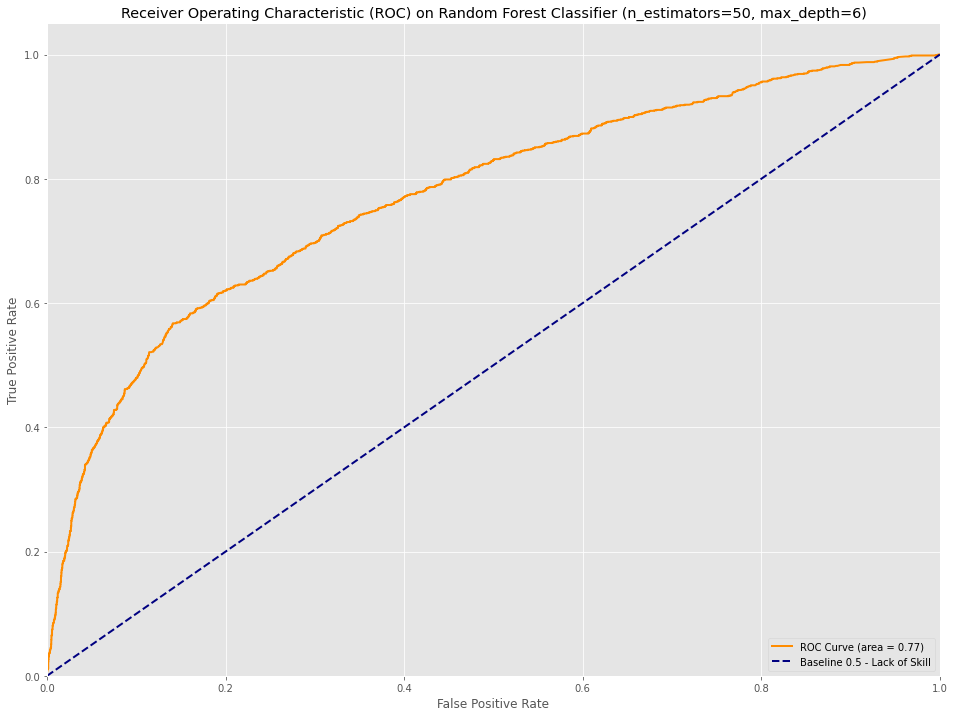

In [32]:
truePR = dict()
falsePR = dict()
roc_auc = dict()


falsePR, truePR, _ = roc_curve(y_test_np, y_probas)
roc_auc = auc(falsePR, truePR)

plt.style.use('ggplot')
plt.figure(figsize=(16,12))
lw = 2
plt.plot(
    falsePR,
    truePR,
    color='darkorange',
    lw=lw,
    label="ROC Curve (area = %0.2f)" % roc_auc,
)

plt.plot([0,1], color='navy', lw=lw, linestyle='--', label='Baseline 0.5 - Lack of Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) on Random Forest Classifier (n_estimators=50, max_depth=6)')
plt.legend(loc='lower right')
plt.savefig('./credit/EDA/randf-bin-roc-auc-plot.png')
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
params = {'n_estimators': [5, 10, 25, 50, 100, 150],
          'criterion': ('gini', 'entropy'),
          'max_depth': [2, 4, 6]}

In [ ]:
rf = RandomForestClassifier()

gs_clf = GridSearchCV(rf, params)

In [ ]:
gs_clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [2, 4, 6],
                         'n_estimators': [5, 10, 25, 50, 100, 150]})

In [ ]:
gs_clf.best_estimator_

RandomForestClassifier(max_depth=6, n_estimators=50)

In [ ]:
grid_rf_results = pd.DataFrame(gs_clf.cv_results_)

In [ ]:
grid_rf_results.iloc[15,:]

mean_fit_time                                                  1.132967
std_fit_time                                                   0.007834
mean_score_time                                                0.030348
std_score_time                                                 0.001368
param_criterion                                                    gini
param_max_depth                                                       6
param_n_estimators                                                   50
params                {'criterion': 'gini', 'max_depth': 6, 'n_estim...
split0_test_score                                                0.8175
split1_test_score                                              0.826875
split2_test_score                                              0.820417
split3_test_score                                              0.816667
split4_test_score                                              0.816042
mean_test_score                                                 

In [ ]:
y_pred_rf1 = gs_clf.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_rf1))

              precision    recall  f1-score   support

           0       0.84      0.96      0.89      4687
           1       0.68      0.34      0.45      1313

    accuracy                           0.82      6000
   macro avg       0.76      0.65      0.67      6000
weighted avg       0.80      0.82      0.80      6000



In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
print(confusion_matrix(y_test, y_pred_rf1))

[[4480  207]
 [ 872  441]]
